10715it [00:01, 8504.97it/s]
2844it [00:00, 11932.01it/s]
1467it [00:00, 10144.05it/s]
1686it [00:00, 11105.64it/s]


<Figure size 432x288 with 0 Axes>

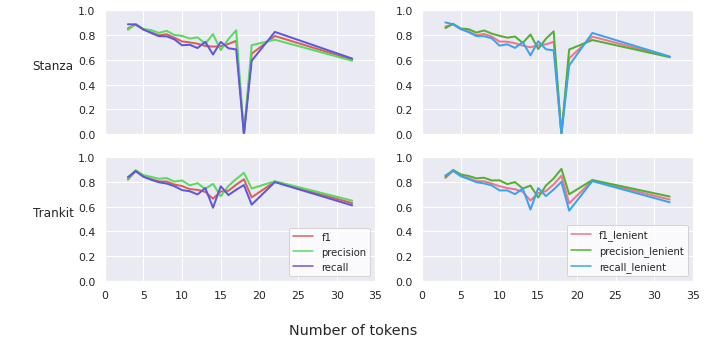

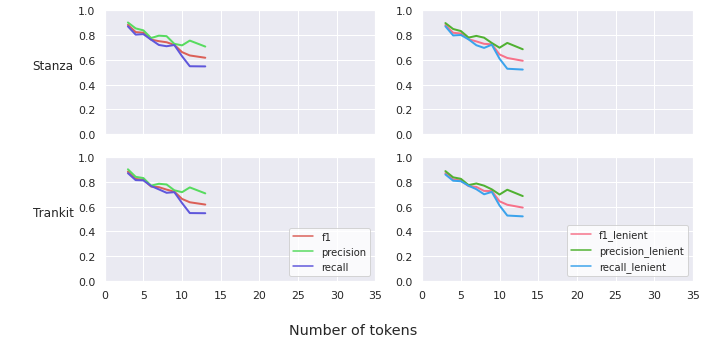

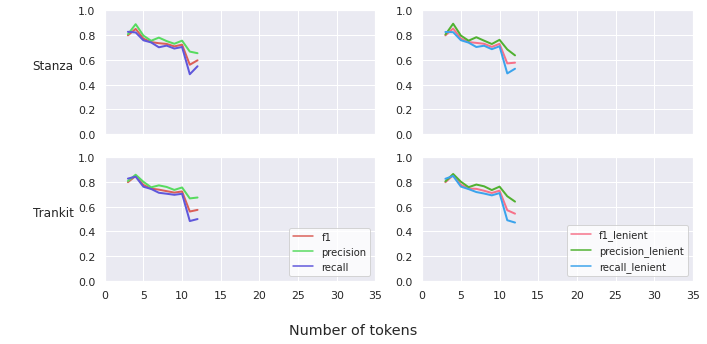

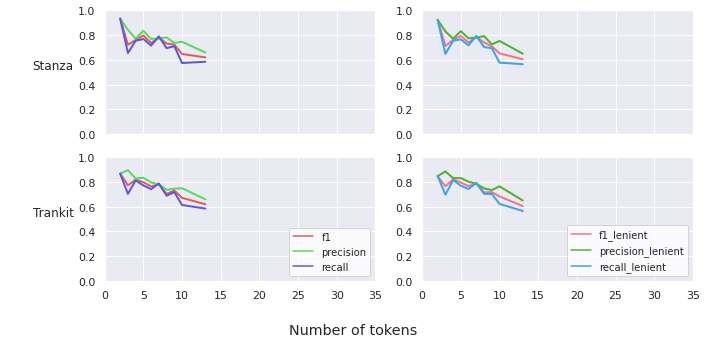

In [22]:
import pandas as pd
from ud_boxer.helpers import PMB
from ud_boxer.sbn_spec import get_doc_id
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
sns.despine()

lang_mapping = {
    'en': 'English',
    'de': 'German',
    'nl': 'Dutch',
    'it': 'Italian',

}

for lang in ['en', 'de', 'nl', 'it']:
    df = pd.DataFrame()
    for data_split in ['dev', 'test', 'eval']:
        if lang != 'en' and data_split == 'eval':
            continue

        s_df = pd.read_csv(f'data/results/rewrite/{lang}/{data_split}/final_stanza.csv')
        t_df = pd.read_csv(f'data/results/rewrite/{lang}/{data_split}/final_trankit.csv')
        s_df['ud_system'] = 'Stanza'
        t_df['ud_system'] = 'Trankit'
        
        df = pd.concat([df, s_df, t_df],  ignore_index=True)

    pmb = PMB(data_split)
    for path in pmb.generator(
        f'../../data/pmb_dataset/pmb-extracted/pmb-4.0.0/data/{lang}/gold', 
        '**/*.tok.off'
    ):
        doc_id = get_doc_id(lang, path)
        df.loc[df['pmb_id'] == doc_id, 'n_tokens'] = len(path.read_text().rstrip().split('\n'))
    

    for col in ['f1', 'precision', 'recall', 'f1_lenient', 'precision_lenient', 'recall_lenient']:
        df[col] = df[col].fillna(0)

    fig, axes = plt.subplots(2, 2, figsize=(10,5))

    for x, sys in enumerate(['Stanza', 'Trankit']):
        for y, mode in enumerate(['', '_lenient']):
            cols = [f'{c}{mode}' for c in ['f1', 'precision', 'recall']]
            cols.append('n_tokens')
            ax = sns.lineplot(
                x='n_tokens',
                y='value', 
                hue='Scores',
                ci=None,
                data=pd.melt(
                    df[df['ud_system'] == sys][cols], 
                    ['n_tokens'], 
                    var_name='Scores'
                ),
                palette="hls" if mode == '' else "husl", 
                linewidth=2.0,
                ax=axes[x, y],
                legend=x==1
            )
            ax.set(ylim=(0, 1.0), xlim=(0,35), xlabel='', ylabel='')
            if x == 0:
                ax.tick_params(bottom=False)
                ax.set(xticklabels=[])

            if x == 1:
                ax.legend(loc='lower right', facecolor='white',  fontsize='10')
            
            if y == 0:
                ax.set(ylabel=sys)
                ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')

    fig.supxlabel('Number of tokens')
    fig.supylabel(' ')
    # fig.suptitle(f'Scores by input length for {lang_mapping[lang]}')
    fig.suptitle(f'')
    fig.tight_layout()

    fig.savefig(f'{lang}_scores_vs_len.png')

10715it [00:01, 8583.40it/s]


<Figure size 432x288 with 0 Axes>

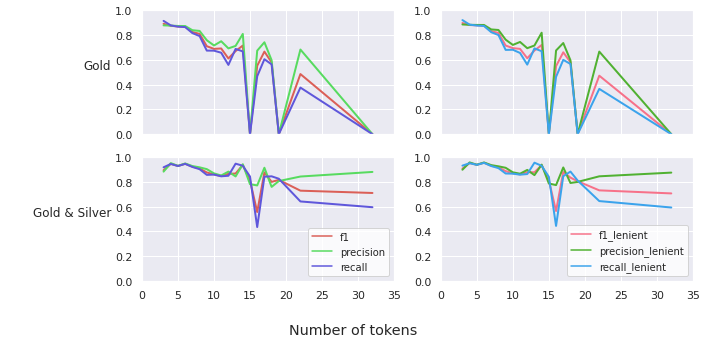

In [23]:
import pandas as pd
from ud_boxer.helpers import PMB
from ud_boxer.sbn_spec import get_doc_id
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
sns.despine()

lang = 'en'
df = pd.DataFrame()
for data_split in ['dev', 'test', 'eval']:
    if lang != 'en' and data_split == 'eval':
        continue

    g_df = pd.read_csv(f'data/results/seq2seq/{data_split}/results_{data_split}_gold_only.csv')
    gs_df = pd.read_csv(f'data/results/seq2seq/{data_split}/results_{data_split}_gold_and_silver.csv')
    g_df['trained_on'] = 'Gold'
    gs_df['trained_on'] = 'Gold & Silver'
    
    df = pd.concat([df, g_df, gs_df],  ignore_index=True)

pmb = PMB(data_split)
for path in pmb.generator(
    f'../../data/pmb_dataset/pmb-extracted/pmb-4.0.0/data/{lang}/gold', 
    '**/*.tok.off'
):
    doc_id = get_doc_id(lang, path)
    df.loc[df['pmb_id'] == doc_id, 'n_tokens'] = len(path.read_text().rstrip().split('\n'))


for col in ['f1', 'precision', 'recall', 'f1_lenient', 'precision_lenient', 'recall_lenient']:
    df[col] = df[col].fillna(0)

fig, axes = plt.subplots(2, 2, figsize=(10,5))

for x, trained in enumerate(['Gold', 'Gold & Silver']):
    for y, mode in enumerate(['', '_lenient']):
        cols = [f'{c}{mode}' for c in ['f1', 'precision', 'recall']]
        cols.append('n_tokens')
        ax = sns.lineplot(
            x='n_tokens',
            y='value', 
            hue='Scores',
            ci=None,
            data=pd.melt(
                df[df['trained_on'] == trained][cols], 
                ['n_tokens'], 
                var_name='Scores'
            ),
            palette="hls" if mode == '' else "husl", 
            linewidth=2.0,
            ax=axes[x, y],
            legend=x==1
        )
        ax.set(ylim=(0, 1.0), xlim=(0,35), xlabel='', ylabel='')
        if x == 0:
            ax.tick_params(bottom=False)
            ax.set(xticklabels=[])

        if x == 1:
            # handles, labels = ax.get_legend_handles_labels()
            ax.legend(loc='lower right', facecolor='white',  fontsize='10')
        
        if y == 0:
            ax.set(ylabel=trained)
            ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')
    
fig.supxlabel('Number of tokens')
fig.supylabel(' ')
# fig.suptitle(f'Scores by input length for {lang_mapping[lang]}')
fig.suptitle('')
fig.tight_layout()

fig.savefig(f'seq2seq_scores_vs_len.png')